In [1]:
import anndata
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import math
import pickle
import seaborn as sns
import scipy
import sys
import scanpy as sc
import pandas as pd

from scbasset.utils import *

2024-04-12 14:46:17.995975: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 14:46:18.044706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 14:46:18.044740: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 14:46:18.045933: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 14:46:18.052388: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 14:46:18.053912: I tensorflow/core/platform/cpu_feature_guard.cc:1

### Choices

In [9]:
###### filtered or not ######
filter_info = 'filtered'
#filter_info = 'not_filtered'
#filter_info = 'filtered_controle'


##### model #####
model_info = 'l2_regularization/0_5'
#model_info = 'l2_regularization/1'
#model_info = 'focal_loss/'

### Enhancer

In [3]:
type_data = 'enhancer'

### Promotor

In [10]:
type_data = 'promotor'

### Enhancer_promotor

In [78]:
type_data ='enhancer_promotor'

# Import data

In [11]:
path = f'../../../results_scbasset/{type_data}_final'

ad_file = f'{path}/data/{filter_info}/cage_{type_data}_ad.h5ad'
trained_model = f'{path}/model/{model_info}/{filter_info}/best_model.h5'
results= f'{path}/model/{model_info}/{filter_info}/results'

In [12]:
os.makedirs(results, exist_ok=True)

# read h5ad file
ad = anndata.read_h5ad(ad_file)

# load model
model = make_model(32, ad.shape[0], show_summary=False)
model.load_weights(trained_model)

2024-04-12 14:54:50.203764: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# intercept vs. depth

Nombre de points sur le graphique : 98


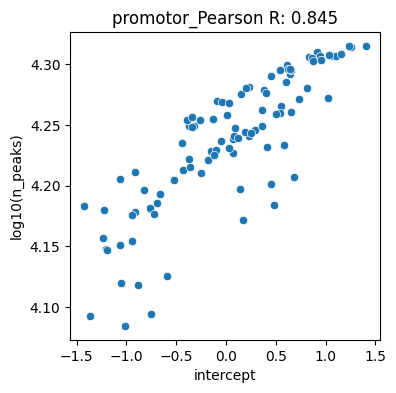

In [13]:
intercept = get_intercept(model) # get_intercept function
sc.pp.filter_cells(ad, min_counts=0)

f, ax = plt.subplots(figsize=(4,4))
r = scipy.stats.pearsonr(intercept, np.log10(ad.obs['n_genes']))[0]
sns.scatterplot(x=intercept, y=np.log10(ad.obs['n_genes']), ax=ax)
ax.set_xlabel('intercept')
ax.set_ylabel('log10(n_peaks)')
ax.set_title(f'{type_data}_Pearson R: %.3f'%r)

nb_points = len(intercept)
print("Nombre de points sur le graphique :", nb_points)

#f.savefig('results/intercept.pdf')

# Embeddings

/home/pascal/Norway/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pascal/Norway/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/pascal/Norway/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


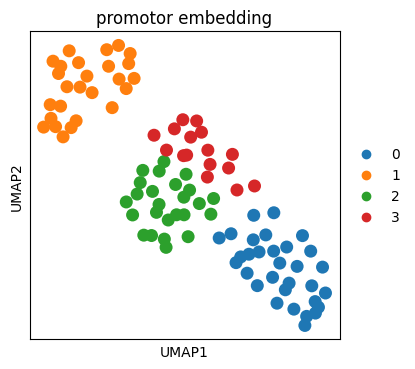

In [14]:
proj = get_cell_embedding(model) # get_cell_embedding function
pd.DataFrame(proj).to_csv(f'{results}/projection_cage_{type_data}.csv')

f, ax = plt.subplots(figsize=(4, 4))
ad.obsm['projection'] = pd.read_csv(f'{results}/projection_cage_{type_data}.csv', index_col=0).values
sc.pp.neighbors(ad, use_rep='projection')
sc.tl.umap(ad)
sc.tl.leiden(ad)
sc.pl.umap(ad, color='leiden', ax=ax, size=350, title = f'{type_data} embedding')

## Patient vs cell line

In [15]:
ad.obs['Patient'] = np.where(ad.obs.index.str.startswith('s'), 'patient', 'cell_line')

ad.obs['Patient'] = ad.obs['Patient'].astype('category')

/home/pascal/Norway/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/pascal/Norway/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


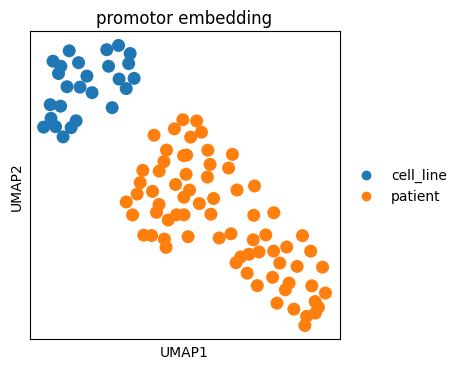

In [16]:
f, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(ad, color='Patient', ax=ax, size=350, title = f'{type_data} embedding')

## Hormone

In [19]:
hormone = pd.read_csv('../../../results_scbasset/data/CAGE/samples_horm_stat.csv', sep = ' ', header = 0)

In [20]:
def hormone_classe(row):
    if row['ER+_HER2-'] == 1:
        return 'ER+_HER2-'
    elif row['HER2+'] == 1:
        return 'HER2+'
    elif row['TNBC'] == 1:
        return 'TNBC'

In [21]:
hormone['Classe'] = hormone.apply(hormone_classe, axis=1)
sample_class_map = dict(zip(hormone['Sample_id'], hormone['Classe']))
ad.obs['Hormone'] = [sample_class_map.get(sample_id, None) for sample_id in ad.obs.index]

/home/pascal/Norway/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/pascal/Norway/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


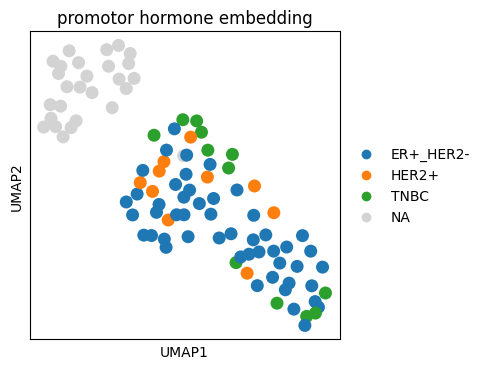

In [22]:
f, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(ad, color='Hormone', ax=ax, size=350, title = f'{type_data} hormone embedding')

In [23]:
ad.write(f'{results}/cage_{type_data}_ad_embedding.h5ad')

# Only patient embeddings

In [24]:
obs_data = ad.obs

# take only the patients
filtered_obs_data = obs_data[obs_data['Patient'].str.contains('patient', case=False)]
filtered_indices = filtered_obs_data.index
filtered_ad = ad[filtered_indices]


/tmp/ipykernel_6757/1230999107.py:6: ImplicitModificationWarning: Setting element `.obsm['projection']` of view, initializing view as actual.
  filtered_ad.obsm['projection'] = projection_data.values
/home/pascal/Norway/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/pascal/Norway/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


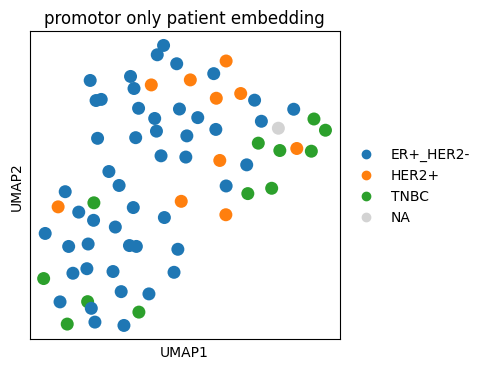

In [25]:
# take the corresponding projection data for the patients
projection_data = pd.read_csv(f'{results}/projection_cage_{type_data}.csv', index_col=0, nrows=72)


f, ax = plt.subplots(figsize=(4, 4))
filtered_ad.obsm['projection'] = projection_data.values
sc.pp.neighbors(filtered_ad, use_rep='projection')
sc.tl.umap(filtered_ad)
sc.tl.leiden(filtered_ad)
sc.pl.umap(filtered_ad, color='Hormone', ax=ax, size=350, title=f'{type_data} only patient embedding')
plt.show()